In [1]:
# Include some libraries
from prelims import DGPrelims
from odetools import RK4Solver
import numpy as np

In this workbook, we run linear, constant-coefficient advection with a DG scheme, and we analyze convergence.

In [2]:
def solve_ode(N, M, NT, T, a, u0):
    # Solve the ODE with DG
    # Given:
    #   N: So that N - 1 is the degree of subelements
    #   M: Number of subelements
    #   NT: So that NT + 2 is the number of time elements
    #   T: Final time
    #   a: The coefficient in the ODE
    #   u0: The initial condition
    # Returns:
    #   prelims: The preliminaries for the DG scheme
    #   The solution at the final time

    # ODE Stuff first:

    # Create the ODE solver
    solver = RK4Solver(NT, (0, T))

    # Now DG stuff:
    # Create the preliminaries
    prelims = DGPrelims(N, M, is_periodic=True)

    # Create the right hand side of the PDE
    def f(u):
        return a * u
    
    # Create the right hand side of the DG scheme
    RHS = lambda u, t: prelims.RHS(f, u)

    # Define initial condition
    initial_u = u0(prelims.x)

    # Plug the DG data into the ODE solver, and return solution
    return prelims, solver.solve(RHS, initial_u, pause_every=20)

Now, we create a way to run the function just to get the error against the true solution:

In [3]:
def evaluate_dg(N, M, NT, T, a, u0):
    # Evaluate the solution at the final time
    # Given:
    #   N: So that N - 1 is the degree of subelements
    #   M: Number of subelements
    #   NT: So that NT + 2 is the number of time elements
    #   T: Final time
    #   a: The coefficient in the ODE
    #   u0: The initial condition
    # Returns:
    #   The solution at the final time

    # Solve the ODE
    prelims, solution_generator = solve_ode(N, M, NT, T, a, u0)

    # Return the solution at the final time
    expected, tf = list(solution_generator)[-1]

    # Construct the true solution at time tf
    actual = [u0(x - a * tf) for x in prelims.x]

    # Return the L∞ error
    return np.max(np.abs(expected - actual))

First, lets take a look at what the solution looks like, if the initial condition is a bell function:

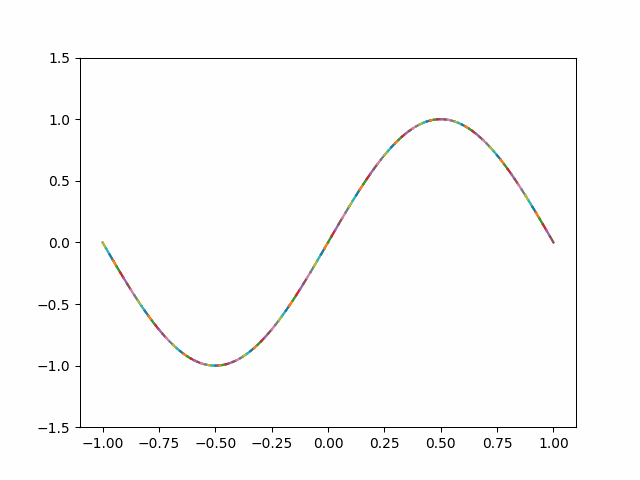

In [4]:
# Initial condition and ODE parameters
u0 = lambda x: np.sin(np.pi * x)
a = 1

# Some example DG parameters
N_example = 4
M_example = 128

# Some time parameters
NT_example = 1000
T_example = 1

from animate import animate
import matplotlib.pyplot as plt

@animate
def animation():
    prelims, generator = solve_ode(N_example, M_example, NT_example, T_example, a, u0)
    for u, t in generator:
        # Plot a frame
        plt.figure()
        plt.plot(prelims.x, u, label='DG Solution')
        plt.plot(prelims.x, u0(prelims.x - a * t), label='True Solution')
        plt.ylim(-1.5, 1.5)

        yield

animation()

Let's see what the error is from these computations:

In [5]:
print("The error was", evaluate_dg(N_example, M_example, NT_example, T_example, a, u0))

The error was 1.612535960315853e-08


Let's see if we can estimate the order of this error, as we change our space or time discretization:

In [6]:
evaluate_given_time = lambda N: evaluate_dg(N_example, 4, N, T_example, a, u0)

from evaluation_tools import unproper_order_func, proper_order_func

unproper_order_func(lambda N: T_example / (N + 1), evaluate_given_time, [16, 32], 2, verbose=True)

Our errors were [0.01460411 0.01462336]
and [0.01462336 0.01462468]


4.041928841712301

We achieve approximately $O(\Delta t^4)$ convergence: this corresponds to the theoretical order for RK4. Let's try to get our space convergence:

In [7]:
T_example = .3

evaluate_given_space = lambda M: evaluate_dg(3, M, 2000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [4, 8, 16, 32, 64], verbose=True)

Our errors were [1.45663382e-01 1.70724858e-02 2.44667278e-03 3.11653653e-04
 3.92233012e-05]


2.949286502966065

We get convergence order 3. What happens when we increase the number of Gauss Lobatto nodes per element?

In [8]:
evaluate_given_space = lambda M: evaluate_dg(4, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [4, 8, 16, 32, 64], verbose=True)

Our errors were [1.90713834e-02 8.25766639e-04 6.38437842e-05 4.13779724e-06
 2.58023416e-07]


3.9987823318065976

Convergence order 4! What happens when we do 5 nodes?

In [9]:
evaluate_given_space = lambda M: evaluate_dg(5, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [4, 8, 16, 32, 64], verbose=True)

Our errors were [1.45485415e-03 3.66068821e-05 1.22474944e-06 4.65115681e-08
 1.35161220e-09]


4.969583324812437

Wooooah! This highlights something incredibly important with DG methods: we can achieve arbitrary order, relatively easily. 

In [10]:
evaluate_given_space = lambda M: evaluate_dg(6, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [4, 8, 16, 32, 64], verbose=True)

Our errors were [8.44778925e-05 1.51628188e-06 2.36261206e-08 3.75295683e-10
 5.73840975e-12]


5.960306169984783

In [12]:
evaluate_given_space = lambda M: evaluate_dg(7, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [4, 8, 16, 32, 64], verbose=True)

Our errors were [5.30948164e-06 4.24647293e-08 3.69025782e-10 2.75943157e-12
 3.95239397e-14]


6.7912144358900814

In [32]:
evaluate_given_space = lambda M: evaluate_dg(8, M, 1000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [2, 4, 8, 16, 32], verbose=True)

Our errors were [7.28694526e-05 2.93834025e-07 1.08203990e-09 4.74642547e-12
 2.65343303e-14]


7.862741425017258

In [20]:
evaluate_given_space = lambda M: evaluate_dg(9, M, 4000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [1, 2, 4, 8], verbose=True)

Our errors were [1.80998821e-03 4.43091030e-06 1.44107574e-08 2.69517464e-11]


8.626739204191658

In [30]:
evaluate_given_space = lambda M: evaluate_dg(10, M, 4000, T_example, a, u0)

proper_order_func(lambda M: 2 / M, evaluate_given_space, [1, 2, 4, 8], verbose=True)

Our errors were [2.56560825e-04 3.49820499e-07 5.72021430e-10 5.11035658e-13]


9.596601928785972